In [1]:
%load_ext autoreload
%autoreload 2

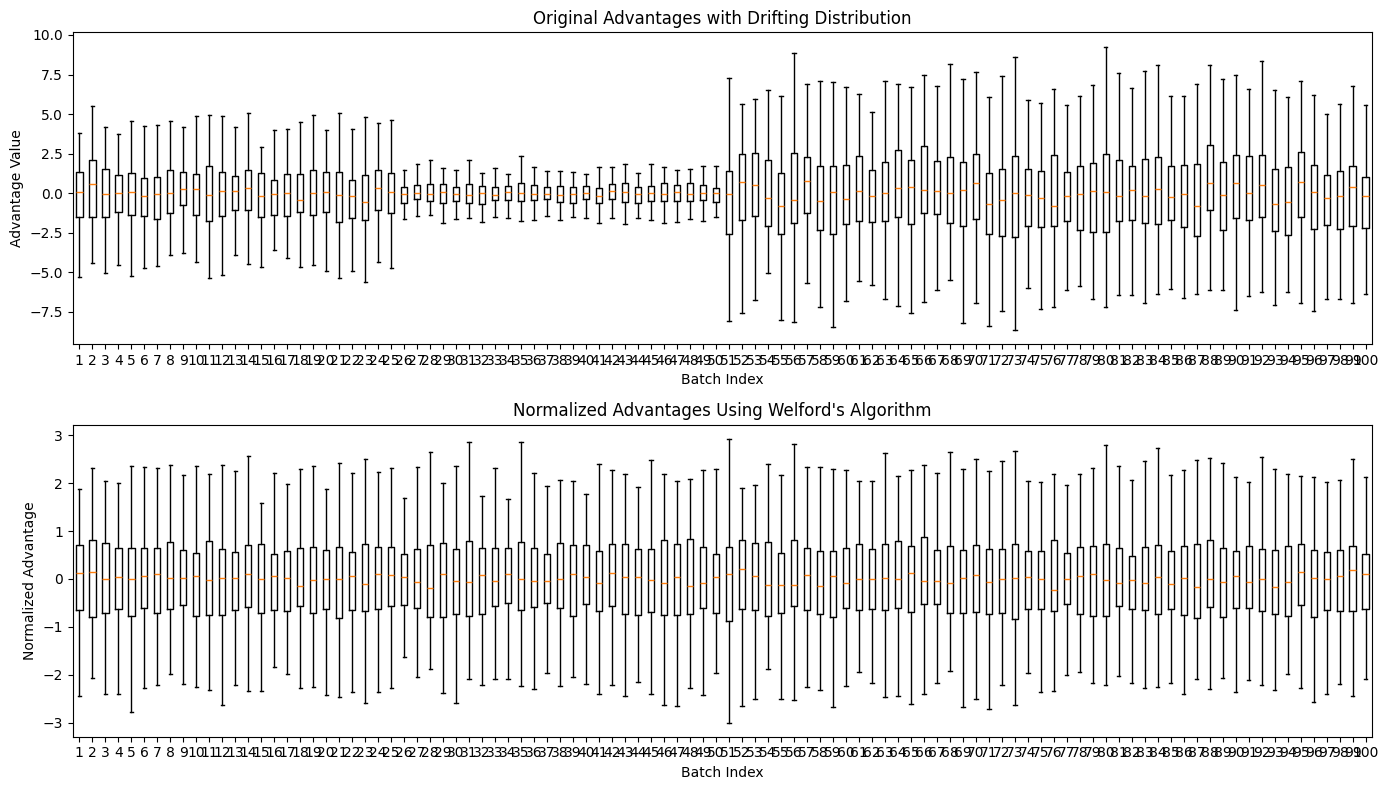

In [137]:
import torch
import matplotlib.pyplot as plt
from typing import Literal


class RunningNormalizer:
    def __init__(self, alpha: float, deviation: Literal["std", "mad"]) -> None:
        """
        Normalizes values using a running mean and deviation.

        Args:
            alpha (float): Alpha parameter [0, 1] for the running mean and deviation:
                - alpha == 0.0: Expanding window/equally weighted normalization.
                - 0.0 < alpha < 1.0: Exponentially weighted normalization.
                - alpha == 1.0: Batch normalization.
            deviation (Literal["std", "mad"]): Type of deviation to use for normalization.
                - "std": Standard deviation.
                - "mad": Mean absolute deviation.
        """
        self.alpha = alpha
        self.deviation = deviation
        self.batch_count = 0
        self.running_mean_sum = 0
        self.running_deviation_sum = 0
        self.running_weight = 0

    @property
    def running_mean(self) -> float:
        return (
            self.running_mean_sum / self.running_weight
            if self.running_weight > 0
            else 0.0
        )

    @property
    def running_deviation(self) -> float:
        return (
            self.running_deviation_sum / self.running_weight
            if self.running_weight > 0
            else 1.0
        )

    def normalize(self, values: torch.Tensor) -> tuple[torch.Tensor, float, float]:
        """
        Normalizes the values tensor using running mean and mean absolute deviation.

        Args:
            values (Tensor): Shape (batch_size,)

        Returns:
            Tensor: Normalized values, Shape (batch_size,)
            float: Batch mean
            float: Batch deviation
        """
        batch_mean = float(values.mean())
        batch_deviation = float(
            values.std() if self.deviation == "std" else abs(values - batch_mean).mean()
        )

        self.running_mean_sum = batch_mean + (1 - self.alpha) * self.running_mean_sum
        self.running_deviation_sum = (
            batch_deviation + (1 - self.alpha) * self.running_deviation_sum
        )
        self.running_weight += (1 - self.alpha) ** self.batch_count
        self.batch_count += 1

        return (
            (values - self.running_mean) / (self.running_deviation + 1e-8),
            batch_mean,
            batch_deviation,
        )


# Parameters
num_batches = 100
batch_size = 100

# Initialize normalizer
normalizer = RunningNormalizer(alpha=0.9**2, deviation="std")

# Lists to store advantages for plotting
original_advantages = []
normalized_advantages = []

for batch_idx in range(num_batches):
    # Define drifting mean and std
    if batch_idx < 25:
        mean, std = 0.0, 2.0
    elif batch_idx < 50:
        mean, std = -0.0, 0.75
    else:
        mean, std = 0.0, 3.0

    # Generate synthetic advantages
    advantages = torch.randn(batch_size) * std + mean
    original_advantages.append(advantages.numpy())

    # Normalize advantages
    normalized, _, _ = normalizer.normalize(advantages)
    normalized_advantages.append(normalized.numpy())

# Plotting
plt.figure(figsize=(14, 8))

# Plot original advantages
plt.subplot(2, 1, 1)
plt.title("Original Advantages with Drifting Distribution")
plt.boxplot(original_advantages, showfliers=False)
plt.ylabel("Advantage Value")
plt.xlabel("Batch Index")

# Plot normalized advantages
plt.subplot(2, 1, 2)
plt.title("Normalized Advantages Using Welford's Algorithm")
plt.boxplot(normalized_advantages, showfliers=False)
plt.ylabel("Normalized Advantage")
plt.xlabel("Batch Index")

plt.tight_layout()
plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Union


ignore_labels_cache: dict[
    tuple[torch.Size, Union[int, float], torch.dtype, torch.device], torch.Tensor
] = {}


def shift(
    labels: torch.Tensor, ignore_label: Optional[Union[int, float]] = None
) -> torch.Tensor:
    if ignore_label is None:
        ignore_label = (
            -100
            if labels.dtype in (torch.int32, torch.int64, torch.int16, torch.int8)
            else float("nan")
        )
    key = (labels.shape[-1:], ignore_label, labels.dtype, labels.device)
    if key not in ignore_labels_cache:
        ignore_labels_cache[key] = torch.full(
            (labels.shape[0], 1), ignore_label, dtype=labels.dtype, device=labels.device
        )
    # Shift labels to compute loss
    # equivalent to doing labels[..., 1:] and logits[..., :-1, :]
    # But this way we dont need to slice the logits. We just add an ignore index to labels.
    return torch.cat((labels[..., 1:], ignore_labels_cache[key]), dim=1)


class RunningNormalizer:
    def __init__(self, alpha: float, deviation: Literal["std", "mad"]) -> None:
        """
        Normalizes values using a running mean and deviation.

        Args:
            alpha (float): Alpha parameter [0, 1] for the running mean and deviation:
                - alpha == 0.0: Expanding window/equal-weight normalization.
                - 0.0 < alpha < 1.0: Exponentially weighted normalization.
                - alpha == 1.0: Batch normalization.
            deviation (Literal["std", "mad"]): Type of deviation to use for normalization.
                - "std": Standard deviation.
                - "mad": Mean absolute deviation.
        """
        self.alpha = alpha
        self.deviation = deviation
        self.batch_count = 0
        self.running_mean_sum = 0
        self.running_deviation_sum = 0
        self.running_weight = 0

    @property
    def running_mean(self) -> float:
        return (
            self.running_mean_sum / self.running_weight
            if self.running_weight > 0
            else 0.0
        )

    @property
    def running_deviation(self) -> float:
        return (
            self.running_deviation_sum / self.running_weight
            if self.running_weight > 0
            else 1.0
        )

    def normalize(self, values: torch.Tensor) -> torch.Tensor:
        """
        Normalizes the values tensor using running mean and mean absolute deviation.

        Args:
            values (Tensor): Shape (batch_size,)

        Returns:
            Tensor: Normalized values, Shape (batch_size,)
            float: Batch mean
            float: Batch deviation
        """
        batch_mean = float(values.mean())
        batch_deviation = float(
            values.std() if self.deviation == "std" else abs(values - batch_mean).mean()
        )

        self.running_mean_sum = batch_mean + (1 - self.alpha) * self.running_mean_sum
        self.running_deviation_sum = (
            batch_deviation + (1 - self.alpha) * self.running_deviation_sum
        )
        self.running_weight += (1 - self.alpha) ** self.batch_count
        self.batch_count += 1

        return (values - self.running_mean) / (self.running_deviation + 1e-8)


class PPOLoss(nn.Module):
    def __init__(
        self,
        clip_epsilon=0.2,
        entropy_coef=0.01,
        advantage_normalizer: Optional[RunningNormalizer] = None,
    ):
        """
        Initializes the PPO Loss module.

        Args:
            clip_epsilon (float): Clipping parameter for PPO (typically between 0.1 and 0.3).
            entropy_coef (float): Coefficient for the entropy bonus to encourage exploration.
            advantage_normalizer (Optional[RunningNormalizer]): Normalizer for advantages.
        """
        super(PPOLoss, self).__init__()
        self.clip_epsilon = clip_epsilon
        self.entropy_coef = entropy_coef
        self.advantage_normalizer = (
            RunningNormalizer(1.0, "std")
            if advantage_normalizer is None
            else advantage_normalizer
        )

    def forward(
        self,
        logits: torch.Tensor,
        tokens: torch.Tensor,
        advantages: torch.Tensor,
        logprobs: torch.Tensor,
        bos_id: Optional[int] = None,
    ) -> tuple[float, int]:
        """
        Computes the PPO loss for sequence data.

        Args:
            logits (Tensor):
                Shape: (batch_size, sequence_length, vocab_size)
                Logits output by the new policy for next token preferences.

            tokens (Tensor):
                Shape: (batch_size, sequence_length)
                Token indices sampled under the old policy.

            advantages (Tensor):
                Shape: (batch_size, sequence_length)
                Advantage estimates for each token.

            logprobs (Tensor):
                Shape: (batch_size, sequence_length)
                Log probabilities of the sampled tokens under the old policy.

            bos_id (Optional[int] = None):
                Index of the beginning of sequence token in the vocabulary. If None, defaults
                to the first token in `tokens`.

        Returns:
            total_loss (Tensor):
                Scalar tensor representing the combined PPO loss.

            num_tokens (int):
                Number of tokens used to compute the loss.
        """
        if bos_id is None:
            bos_id = int(tokens.view(-1)[0].item())
        # Flatten logits tensor to shape (batch_size * sequence_length, vocab_size)
        logits = logits.view(-1, logits.size(-1))
        tokens = shift(tokens, ignore_label=bos_id).view(
            -1
        )  # Shape: (batch_size * sequence_length,)
        advantages = shift(advantages).view(
            -1
        )  # Shape: (batch_size * sequence_length,)
        logprobs = shift(logprobs).view(-1)  # Shape: (batch_size * sequence_length,)

        # Compute new log probabilities using the sampled labels
        # Create a Categorical distribution from logits
        dist = torch.distributions.Categorical(
            logits=logits
        )  # Shape: (batch_size * sequence_length,)

        # Calculate new log probabilities of the taken actions
        new_logprobs = dist.log_prob(tokens)  # Shape: (batch_size * sequence_length,)

        # Calculate entropy for each token
        entropy = dist.entropy()  # Shape: (batch_size * sequence_length,)

        # Create mask where tokens != bos_id and advantages and logprobs are not NaN
        mask = (
            (tokens != bos_id) & (~torch.isnan(advantages)) & (~torch.isnan(logprobs))
        )  # Shape: (batch_size * sequence_length,)
        num_tokens = int(mask.sum().item())

        # Apply mask
        new_logprobs = new_logprobs[mask]  # Shape: (num_valid_tokens,)
        logprobs = logprobs[mask]  # Shape: (num_valid_tokens,)
        advantages = advantages[mask]  # Shape: (num_valid_tokens,)
        entropy = entropy[mask]  # Shape: (num_valid_tokens,)

        # Normalize advantages
        advantages = self.advantage_normalizer.normalize(advantages)

        # Calculate the probability ratio (π_θ(a|s) / π_θ_old(a|s))
        ratio = torch.exp(new_logprobs - logprobs)  # Shape: (num_valid_tokens,)

        # Calculate the surrogate losses
        surrogate1 = ratio * advantages  # Shape: (num_valid_tokens,)
        surrogate2 = (
            torch.clamp(ratio, 1.0 - self.clip_epsilon, 1.0 + self.clip_epsilon)
            * advantages
        )  # Shape: (num_valid_tokens,)

        # Take the minimum of the two surrogate losses
        policy_loss = -torch.min(surrogate1, surrogate2).sum()  # Scalar

        # Entropy bonus (to encourage exploration)
        entropy_bonus = entropy.sum()  # Scalar

        # Total loss
        total_loss = policy_loss - self.entropy_coef * entropy_bonus  # Scalar

        return total_loss, num_tokens


# Test the PPO loss module
logits = torch.randn(4, 10, 100)
tokens = torch.randint(0, 100, (4, 10))
advantages = torch.randn(4, 10)
logprobs = torch.randn(4, 10)
ppo_loss = PPOLoss()
total_loss, policy_loss, entropy_bonus = ppo_loss(logits, tokens, advantages, logprobs)

In [11]:
total_loss, policy_loss, entropy_bonus

(tensor(0.2619), tensor(0.3033), tensor(4.1388))

In [ ]:
import torch
import torch.nn.functional as F
from typing import Optional


class ForwardKLLoss(torch.nn.Module):
    """
    The Kullback-Leibler divergence loss for valid indexes.
    Implementation of https://github.com/jongwooko/distillm/blob/17c0f98bc263b1861a02d5df578c84aea652ee65/distillm/losses.py

    Args:
        ignore_index (int):  Specifies a target value that is ignored and does not contribute to the input gradient.
            The loss is divided over non-ignored targets.
            Default: -100.
    """

    def __init__(self, ignore_index: int = -100):
        super().__init__()
        self.ignore_index = ignore_index

    def forward(
        self,
        student_logits: torch.Tensor,
        teacher_logits: torch.Tensor,
        labels: torch.Tensor,
        normalize: bool = True,
    ) -> torch.Tensor:
        """
        Args:
            student_logits (torch.Tensor): logits from student model of shape
                (batch_size*num_tokens, vocab_size).
            teacher_logits (torch.Tensor): logits from teacher model of shape
                (batch_size*num_tokens, vocab_size).
            labels (torch.Tensor): Ground truth labels of shape
                (batch_size, vocab_size).
            normalize (bool): Whether to normalize the loss by the number of unmasked elements.

        Returns:
            torch.Tensor: KL divergence loss of shape (1,).
        """

        teacher_prob = F.softmax(teacher_logits, dim=-1, dtype=torch.float32)
        inf_mask = torch.isinf(student_logits)
        student_logprob = F.log_softmax(student_logits, dim=-1, dtype=torch.float32)
        prod_probs = torch.masked_fill(teacher_prob * student_logprob, inf_mask, 0)
        x = torch.sum(prod_probs, dim=-1).view(-1)
        mask = (labels != self.ignore_index).int()
        if not normalize:
            return -torch.sum(x * mask.view(-1), dim=0)
        if torch.sum(mask.view(-1), dim=0) == 0:
            return torch.tensor(0.0, device=x.device)
        return -torch.sum(x * mask.view(-1), dim=0) / torch.sum(mask.view(-1), dim=0)
    

class PPOLoss(torch.nn.Module):
    """
    Proximal Policy Optimization loss function.
    
    Args:
        clip_range (float): Clipping parameter for PPO, typically between 0.1 and 0.3
        value_loss_coef (float): Coefficient for value function loss
        entropy_coef (float): Coefficient for entropy bonus
    """
    def __init__(self, clip_range: float = 0.2, value_loss_coef: float = 0.5, entropy_coef: float = 0.01):
        super().__init__()
        self.clip_range = clip_range
        self.value_loss_coef = value_loss_coef 
        self.entropy_coef = entropy_coef

    def forward(
        self,
        logprobs: torch.Tensor,
        old_logprobs: torch.Tensor,
        values: torch.Tensor,
        old_values: torch.Tensor,
        advantages: torch.Tensor,
        returns: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
    ) -> tuple[torch.Tensor, dict[str, torch.Tensor]]:
        """
        Args:
            logprobs (torch.Tensor): Log probabilities of current policy
            old_logprobs (torch.Tensor): Log probabilities of old policy
            values (torch.Tensor): Value estimates of current policy
            old_values (torch.Tensor): Value estimates of old policy  
            advantages (torch.Tensor): Advantage estimates
            returns (torch.Tensor): Discounted returns
            mask (Optional[torch.Tensor]): Optional mask for valid tokens
            
        Returns:
            Tuple[torch.Tensor, Dict[str, torch.Tensor]]: Total loss and dictionary of component losses
        """
        # Policy loss
        ratio = torch.exp(logprobs - old_logprobs)
        policy_loss1 = -advantages * ratio
        policy_loss2 = -advantages * torch.clamp(ratio, 1.0 - self.clip_range, 1.0 + self.clip_range)
        policy_loss = torch.max(policy_loss1, policy_loss2)

        # Value loss 
        value_pred_clipped = old_values + torch.clamp(values - old_values, -self.clip_range, self.clip_range)
        value_loss1 = (values - returns) ** 2
        value_loss2 = (value_pred_clipped - returns) ** 2
        value_loss = 0.5 * torch.max(value_loss1, value_loss2)

        # Entropy bonus
        entropy = -(torch.exp(logprobs) * logprobs).sum(-1)

        # Combine losses
        if mask is not None:
            policy_loss = (policy_loss * mask).mean()
            value_loss = (value_loss * mask).mean()
            entropy = (entropy * mask).mean()
        else:
            policy_loss = policy_loss.mean()
            value_loss = value_loss.mean()
            entropy = entropy.mean()

        total_loss = policy_loss + self.value_loss_coef * value_loss - self.entropy_coef * entropy

        return total_loss, {
            'policy_loss': policy_loss,
            'value_loss': value_loss,
            'entropy': entropy
        }
    

class ReinforceLoss(torch.nn.Module):
    """
    Implements the REINFORCE loss function for policy gradient reinforcement learning.
    
    This computes the policy gradient loss using the REINFORCE algorithm:
    L = -log π(a|s) * R
    where π(a|s) is the policy probability of taking action a in state s,
    and R is the reward/return.
    """
    def __init__(self):
        super().__init__()

    def forward(
        self,
        logprobs: torch.Tensor,  # Log probabilities from policy network
        rewards: torch.Tensor,    # Rewards/returns
        mask: Optional[torch.Tensor] = None,  # Optional mask for valid tokens
    ) -> tuple[torch.Tensor, dict[str, torch.Tensor]]:
        """
        Args:
            logprobs (torch.Tensor): Log probabilities from policy network
            rewards (torch.Tensor): Rewards/returns for each action
            mask (Optional[torch.Tensor]): Optional mask for valid tokens
            
        Returns:
            Tuple[torch.Tensor, Dict[str, torch.Tensor]]: Total loss and component losses
        """
        # Basic REINFORCE loss
        policy_loss = -logprobs * rewards

        # Apply mask if provided
        if mask is not None:
            policy_loss = (policy_loss * mask).mean()
        else:
            policy_loss = policy_loss.mean()

        # Return total loss and components
        return policy_loss, {
            'policy_loss': policy_loss,
        }


In [ ]:
from lib.recipes.full_finetune import ComponentConfig, FullFinetuneConfig, recipe_main
import subprocess
from torch.optim.adamw import AdamW
from torchtune.datasets import alpaca_dataset
from torchtune.models.llama3 import llama3_tokenizer
from torchtune.models.llama3_1 import llama3_1_8b
from torchtune.modules.loss import CEWithChunkedOutputLoss
from torchtune.training import FullModelHFCheckpointer
from torchtune.training.metric_logging import DiskLogger
from typing import Any

PLACEHOLDER: Any = None

checkpoint_dir = subprocess.run(
    "HF_HUB_ENABLE_HF_TRANSFER=1 huggingface-cli download NousResearch/Hermes-2-Theta-Llama-3-8B",
    shell=True,
    capture_output=True,
    text=True,
).stdout.strip()

recipe_main(
    FullFinetuneConfig(
        # Tokenizer
        tokenizer=ComponentConfig(
            llama3_tokenizer,  # type: ignore
            path="/home/ubuntu/atreides/.venv/lib/python3.12/site-packages/llama_models/llama3/api/tokenizer.model",
            max_seq_len=None,
        ),
        # Dataset
        dataset=ComponentConfig(alpaca_dataset, tokenizer=PLACEHOLDER, packed=False),
        seed=None,
        shuffle=True,
        # Model
        model=ComponentConfig(llama3_1_8b),
        # Checkpointer
        checkpointer=ComponentConfig(
            FullModelHFCheckpointer,
            checkpoint_dir=checkpoint_dir,
            checkpoint_files=[
                "model-00001-of-00004.safetensors",
                "model-00002-of-00004.safetensors",
                "model-00003-of-00004.safetensors",
                "model-00004-of-00004.safetensors",
            ],
            recipe_checkpoint=None,
            output_dir="/tmp/Hermes-2-Theta-Llama-3-8B/",
            model_type="LLAMA3",
        ),
        resume_from_checkpoint=False,
        # Fine-tuning arguments
        batch_size=12,
        epochs=3,
        optimizer=ComponentConfig(AdamW, params=PLACEHOLDER, lr=2e-5, fused=True),
        loss=ComponentConfig(CEWithChunkedOutputLoss),
        max_steps_per_epoch=None,
        compile=True,
        optimizer_in_bwd=False,
        gradient_accumulation_steps=1,
        # Training env
        device="cuda",
        # Memory management
        enable_activation_checkpointing=True,
        enable_activation_offloading=False,
        custom_sharded_layers=["tok_embeddings", "output"],
        # Reduced precision
        dtype="bf16",
        # Logging
        metric_logger=ComponentConfig(
            DiskLogger, log_dir="/home/ubuntu/atreides/experiments/logs"
        ),
        output_dir="/home/ubuntu/atreides/experiments/logs",
        log_every_n_steps=16,
        log_peak_memory_stats=True,
    )
)

In [2]:
from lib.tokenizer import Tokenizer

tokenizer = Tokenizer(model="NousResearch/Hermes-2-Theta-Llama-3-8B")

/home/ubuntu/atreides/.venv/lib/python3.12/site-packages/vllm/connections.py:8: RuntimeWarning: Failed to read commit hash:
No module named 'vllm._version'
  from vllm.version import __version__ as VLLM_VERSION


INFO 10-31 00:23:16 llm_engine.py:237] Initializing an LLM engine (vdev) with config: model='NousResearch/Hermes-2-Theta-Llama-3-8B', speculative_config=None, tokenizer='NousResearch/Hermes-2-Theta-Llama-3-8B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=NousResearch/Hermes-2-Theta-Llama-3-8B, use_v2_block_manager=True, num_scheduler_steps=1, chunked_

In [3]:
from torchtune.models.llama3_1 import llama3_1_8b

model = llama3_1_8b()

In [4]:
import glob
import subprocess

model_dir = subprocess.run(
    "HF_HUB_ENABLE_HF_TRANSFER=1 huggingface-cli download NousResearch/Hermes-2-Theta-Llama-3-8B",
    shell=True,
    capture_output=True,
    text=True,
).stdout.strip()

print(model_dir)

/home/ubuntu/.cache/huggingface/hub/models--NousResearch--Hermes-2-Theta-Llama-3-8B/snapshots/57a73110702e7b05ba3f39fef36297454c680725


In [5]:
import os
from torchtune.training.checkpointing import FullModelHFCheckpointer

output_dir = "./models/test"
os.makedirs(output_dir, exist_ok=True)

checkpointer = FullModelHFCheckpointer(
    checkpoint_dir=model_dir,
    checkpoint_files=glob.glob(f"{model_dir}/*.safetensors")
    + glob.glob(f"{model_dir}/*.pt"),
    output_dir=output_dir,
    model_type="LLAMA3",  # type: ignore
)
state_dict = checkpointer.load_checkpoint()
state_dict.keys()

dict_keys(['model'])

In [6]:
model.load_state_dict(state_dict["model"])

<All keys matched successfully>

In [7]:
# Check if model is compiled
is_compiled = hasattr(model, '_orig_mod')
print(is_compiled)

False


In [8]:
from lib.rl import Completion

root = Completion.model_validate_json(open("./data/completions.json").read())

In [10]:
max_length = 0
for leaf in root.leaves():
    length = len(tokenizer.encode(leaf.all_message_params()))
    if length > max_length:
        max_length = length
        clear_output()
        print(max_length)

In [19]:
len(tokenizer.encode([{"role": "user", "content": "Hello, how are you?"},]))

12

In [10]:
import os
import shutil

epoch = 1

# Save the model
checkpointer.save_checkpoint(dict(model=model.state_dict()), epoch)

# Create target directory if it doesn't exist
os.makedirs(f"{output_dir}/{epoch:04d}", exist_ok=True)

# Copy all non-safetensors files from model_dir to target
for file in os.listdir(model_dir):
    if not file.endswith(".safetensors") and not file.endswith(".pt"):
        src = os.path.join(model_dir, file)
        dst = os.path.join(f"{output_dir}/{epoch:04d}", file)
        shutil.copy2(src, dst)

# Move all .pt files from ./models/test to ./models/test/0000
for file in os.listdir(output_dir):
    if file.endswith(".pt"):
        src = os.path.join(output_dir, file)
        dst = os.path.join(f"{output_dir}/{epoch:04d}", file)
        shutil.move(src, dst)

INFO:torchtune.utils._logging:Model checkpoint of size 9.95 GB saved to models/test/hf_model_0001_1.pt
INFO:torchtune.utils._logging:Model checkpoint of size 10.00 GB saved to models/test/hf_model_0002_1.pt
INFO:torchtune.utils._logging:Model checkpoint of size 9.83 GB saved to models/test/hf_model_0003_1.pt
INFO:torchtune.utils._logging:Model checkpoint of size 2.34 GB saved to models/test/hf_model_0004_1.pt
INFO:torchtune.utils._logging:Saving final epoch checkpoint.
INFO:torchtune.utils._logging:The full model checkpoint, including all weights and configurations, has been saved successfully.You can now use this checkpoint for further training or inference.


In [7]:
def get_tokens(messages: list[dict]) -> list[int]:
    generate = llm.generate

    def get_tokens(prompts: list[dict], *args: object, **kwargs: object) -> list[int]:
        return llm.get_tokenizer().encode(prompts[0]["prompt"])

    llm.generate = get_tokens  # type: ignore
    tokens = llm.chat(messages)  # type: ignore
    llm.generate = generate  # type: ignore
    return tokens  # type: ignore


get_tokens([dict(role="user", content=prompt)])

[128000,
 128000,
 128002,
 882,
 198,
 1966,
 264,
 8369,
 10683,
 1938,
 19367,
 11,
 480,
 285,
 6853,
 323,
 58280,
 7731,
 1523,
 311,
 1514,
 264,
 16736,
 23347,
 1847,
 382,
 7009,
 35105,
 220,
 18,
 30881,
 315,
 7563,
 11,
 1855,
 369,
 264,
 8821,
 955,
 315,
 2038,
 24306,
 315,
 279,
 2768,
 1473,
 78524,
 1002,
 512,
 12,
 9083,
 81818,
 198,
 12,
 4491,
 13,
 7997,
 198,
 12,
 18083,
 13,
 5929,
 271,
 29314,
 512,
 12,
 73997,
 30133,
 198,
 12,
 62302,
 198,
 12,
 30982,
 28905,
 271,
 14330,
 512,
 12,
 11166,
 198,
 12,
 50767,
 198,
 12,
 39190,
 10637,
 271,
 6153,
 27716,
 320,
 438,
 89447,
 8,
 19301,
 832,
 3786,
 505,
 1855,
 1912,
 323,
 25012,
 1124,
 304,
 279,
 6278,
 315,
 279,
 2007,
 17011,
 785,
 11,
 814,
 75371,
 279,
 9861,
 7563,
 323,
 27023,
 704,
 279,
 2768,
 311,
 1855,
 2851,
 1473,
 12,
 19367,
 25,
 220,
 17,
 7563,
 198,
 12,
 480,
 285,
 6853,
 25,
 220,
 17,
 7563,
 4417,
 43,
 26645,
 518,
 364,
 36412,
 81818,
 1329,
 12,
 58280,
 25,

In [9]:
import gc
import torch
from vllm.distributed.parallel_state import destroy_model_parallel

destroy_model_parallel()
del llm.llm_engine.model_executor.driver_worker  # type: ignore
gc.collect()
torch.cuda.empty_cache()

In [10]:
model.to("cuda")

TransformerDecoder(
  (tok_embeddings): Embedding(128256, 4096)
  (layers): ModuleList(
    (0-31): 32 x TransformerSelfAttentionLayer(
      (attn): MultiHeadAttention(
        (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
        (output_proj): Linear(in_features=4096, out_features=4096, bias=False)
        (pos_embeddings): Llama3ScaledRoPE()
      )
      (mlp): FeedForward(
        (w1): Linear(in_features=4096, out_features=14336, bias=False)
        (w2): Linear(in_features=14336, out_features=4096, bias=False)
        (w3): Linear(in_features=4096, out_features=14336, bias=False)
        (activation): SiLU()
      )
      (sa_norm): RMSNorm()
      (mlp_norm): RMSNorm()
      (sa_scale): Identity()
      (mlp_scale): Identity()
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=4096, out_features=128256

In [11]:
next(model.parameters()).device

device(type='cuda', index=0)

In [16]:
import torch
from torchtune.generation import generate

result = generate(
    model,
    torch.tensor([get_tokens([dict(role="user", content=prompt)])], device="cuda"),
    max_generated_tokens=10,
)

In [17]:
print(llm.get_tokenizer().decode(result[0].squeeze().tolist()))

<|begin_of_text|><|begin_of_text|><|im_start|>user
On a warm spring day Summer, Giselle and Connor sat down to play a casual mystery game.

They assembled 3 decks of cards, each for a separate type of information composed of the following:

Suspect:
- Miss Scarlet
- Mr. Green
- Mrs. White

Weapon:
- Candlestick
- Knife
- Lead Pipe

Room:
- Hall
- Lounge
- Dining Room

After randomly (and blindly) choosing one card from each group and placing them in the middle of the table facedown, they shuffled the remaining cards and dealt out the following to each player:

- Summer: 2 cards
- Giselle: 2 cards ('Lounge', 'Miss Scarlet')
- Connor: 2 cards

The game proceeded as follows:

1. On their turn, a player asked about a set of exactly 3 cards, one from each of the game's categories. (Note: Players could ask about any cards, including those in their own hand.)
2. The player directed this question to the other players in clockwise order, starting with the player to their left.
3. If a player ha

In [22]:
torch.tensor([get_tokens([dict(role="user", content=prompt)])] * 2, device="cuda").shape

torch.Size([2, 585])

In [23]:
model.forward(torch.tensor([get_tokens([dict(role="user", content=prompt)])] * 2, device="cuda"))

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 39.38 GiB of which 37.38 MiB is free. Including non-PyTorch memory, this process has 39.33 GiB memory in use. Of the allocated memory 38.62 GiB is allocated by PyTorch, and 166.44 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)